# Plastic Model

In [1]:
import math
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import random
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

verplaatsingskans_inwoner = 5
verplaatsingskans_vuilnisman = 80
hoeveelheid_vuilnismannen = 10
hoeveelheid_plasticpolitie = 10
vuilnisman_actief = 0
vuilnisman_moe = 5

lst1 = [1.6, 1.5,1,1.5] 
lst2 = [1.76,1.65,1.65] 
lst3 = [1.44,1.35,1.35]

lst = lst1

In [ ]:
#Onze scenarios
#basecase: de inwoners lopen willekeurig rond en worden beinvloedt (zowel positief als negatief) door hun buren. Je motivatie neemt toe als je buren ook recyclen en af wnr ze iets anders doen- 
#scenario 1: er lopen vuilnismannen rond. Wanneer een inwoner een vuilnisman ziet, stopt hij met zijn plastic op straat gooien en begint het bij het restafval te gooien. De vuilnismannen worden actief
#als er x aantal agenten om zich heen afval op straat gooien en zijn na 5 tijdstappen moe en worden inactief.
#scenario 2: er komen beloningen voor mensen die hun afval recyclen. Die voor een toename van 10 zorgt om te recyclen 
#Er komt een boete voor mensen die hun afval op straat gooien, wat voor een toename van motivatie zorgt van 15 bijv. Er komt ook een boete
#voor mensen die hun afval bij het restafval gooien. Deze boete is wel minder hoog, dus de motivatieboost is minder (bijv. 10), maar nog steeds aanwezig. Je krijgt altijd een boete wanneer je betrapt wordt door een 
#door een politieagent (nieuwe agent). 

In [2]:
class plastic(Model):
    basecase = True
    beleid1 = False
    beleid2 = False
    def __init__(self, hoogte = 30, breedte = 30, dichtheid = 70, hoeveelheidv_actief = 0.50, hoeveelheidpp_actief = 0.50,
                motivatie_recycling = 52.5, motivatie_straat = 20, seed = 40):
        self.hoogte = hoogte
        self.breedte = breedte
        self.dichtheid = dichtheid
        
        #self.hoeveelheid_straat = abs(self.hoeveelheid_restafval - self.hoeveelheid_straat)
        self.hoeveelheidv_actief = hoeveelheidv_actief
        self.hoeveelheidpp_actief = hoeveelheidpp_actief
        self.motivatie_recycling = motivatie_recycling
        self.motivatie = motivatie_straat
        
        #gkleiner dan 0.75 ben je een recyclaar omdat 75% nu al recycled. 
        #groter dan 0.85  dan gooi je bij het restafval
        # verschil tussen recycle en rest = je gooit het op straat
        
        self.schedule = RandomActivation (self)
        self.grid = SingleGrid(hoogte, breedte, torus = True) 
          #zo krijg je nooit meer dan 100% 
        
        model_info = {"recycle" : lambda m: self.count_inwoner(m, "recycle"),
                      "straat" : lambda m: self.count_inwoner(m,  "straat"), 
                      "restafval" : lambda m: self.count_inwoner(m, "restafval"),
                     "actief" : lambda m: self.count_vuilnisman(m, "actief"),
                     "inactief": lambda m: self.count_vuilnisman(m, "inactief"),
                     "actief_p": lambda m: self.count_plasticpolitie(m, "actief_p"),
                      "inactief_p": lambda m: self.count_plasticpolitie(m, "inactief_p")} 
        agent_info = {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1],
                     "conditie":"conditie",
                     "motivatie":"motivatie", "buren_recycle": "buren_recycle",
                     "buren_straat": "buren_straat", "buren_restafval":"buren_restafval"}
        
        #Misschien nice een datacollector toe te voegen voor agents met de bijbehorende motivatie.
        
        self.datacollector = DataCollector(model_reporters = model_info, agent_reporters = agent_info)
        
        #Agenten maken
        for c in self.grid.coord_iter():
            x = c[1]
            y = c[2]
            
            if self.random.randint(0,101) < self.dichtheid: #creer een agent en anders is er een leeg vakje
                    
                agent = inwoners((x,y), self, conditie = "recycle", motivatie = 0,  initiele_motivatie = 0, 
                                 motivatie_boete = 0, betrapt_straat = False, betrapt_restafval = False, motivatie_recycle = 52.5, motivatie_straat= 20, buren_recycle = 0, buren_straat = 0, buren_restafval = 0) #deze gedrag klopt wellicht niet
                self.grid.position_agent(agent, x, y)
                self.schedule.add(agent)
                
                agent.initiele_motivatie = self.random.randint(0,101)
                agent.motivatie = agent.initiele_motivatie 
                if agent.initiele_motivatie > motivatie_recycling:
                    agent.conditie = "recycle"

                elif agent.initiele_motivatie < motivatie_straat:
                    agent.conditie = "straat" 

                else:
                    agent.conditie = "restafval"
              
            elif self.random.randint(0,101) < hoeveelheid_vuilnismannen:
                agent = vuilnisman((x,y),self, conditie = "actief", actieve_modus = 0)
                if self.beleid1: # hier activeren we scenario 1!
                    self.grid.position_agent(agent,x,y)
                    self.schedule.add(agent)
                    if self.random.random() <= hoeveelheidv_actief:
                        agent.conditie = "actief"
                    else:
                        agent.conditie = "inactief"
                        
            elif self.random.randint(0,101) < hoeveelheid_plasticpolitie:
                agent = plasticpolitie((x,y), self, conditie = "actief_p")
                if self.beleid2:
                    self.grid.position_agent(agent,x,y)
                    self.schedule.add(agent)
                    if self.random.random()< hoeveelheidpp_actief:
                        agent.conditie = "actief_p"
                    else:
                        agent.conditie = "inactief_p"
                
        self.datacollector.collect(self)
        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        
        
            
    @staticmethod
            
    def count_inwoner(model, inwoner_conditie):
        count_inwoner = 0
        for inwoner in model.schedule.agents:
            if inwoner.conditie == inwoner_conditie:
                count_inwoner+=1
        return count_inwoner 
    
    @staticmethod
    
    def count_vuilnisman(model, vuilnisman_conditie):
        count_vuilnisman = 0
        for vuilnisman in model.schedule.agents:
            if vuilnisman.conditie == vuilnisman_conditie:
                count_vuilnisman += 1
        return count_vuilnisman
    
    @staticmethod
    
    def count_plasticpolitie(model, plasticpolitie_conditie):
        count_plasticpolitie = 0
        for plasticpolitie in model.schedule.agents:
            if plasticpolitie.conditie == plasticpolitie_conditie:
                count_plasticpolitie += 1
        return count_plasticpolitie
    

    
class inwoners(Agent):
    beleid2 = False
    def __init__(self, positie, model, conditie, motivatie, motivatie_boete,
                 initiele_motivatie, betrapt_straat, betrapt_restafval, motivatie_recycle, motivatie_straat, buren_recycle, buren_straat, buren_restafval):
        super().__init__(positie, model)
        self.positie = positie
        self.conditie = conditie
        self.motivatie = motivatie 
        self.motivatie_boete = motivatie_boete
        self.initiele_motivatie = initiele_motivatie
        self.betrapt_straat = betrapt_straat
        self.betrapt_restafval = betrapt_restafval
        self.motivatie_recycle = motivatie_recycle
        self.motivatie_straat = motivatie_straat
        self.buren_recycle = buren_recycle
        self.buren_straat = buren_straat
        self.buren_restafval = buren_restafval

    def step(self):
        self.buren_recycle = 0
        self.buren_straat = 0
        self.buren_restafval = 0
        buren_rc = 0
        buren_s = 0
        buren_ra = 0
        buren_vuilnisman = 0
        for buren in self.model.grid.neighbor_iter(self.positie):
            if buren.conditie == "recycle" and self.conditie != "recycle": 
                self.buren_recycle += 1
                buren_rc += 1
            if buren.conditie == "recycle" and self.conditie == "recycle": 
                self.buren_recycle += 1
            if buren.conditie == "restafval" and self.conditie  != "restafval":   
                self.buren_recycle += 1
                buren_ra += 1
            if buren.conditie == "restafval" and self.conditie  == "restafval":   
                self.buren_restafval += 1
            if  buren.conditie == "straat" and self.conditie != "straat":   
                self.buren_straat += 1
                buren_s += 1
            if  buren.conditie == "straat" and self.conditie == "straat":   
                self.buren_straat += 1
            if buren.conditie == "actief" and self.conditie == "straat":
                buren_vuilnisman += 1
                
        if buren_rc > 5:
            self.motivatie += lst[0]
        elif buren_s > 5: 
            self.motivatie += lst[1]
        elif buren_ra > 5:
            self.motivatie += lst[2]
        if buren_vuilnisman > 0:
            self.motivatie += lst[3]
                
        
                
                
        if self.random.randint(0,101) < verplaatsingskans_inwoner: #hier gaan we verplaatsen!
            self.model.grid.move_to_empty(self)
            
    
        if self.beleid2:
            if self.betrapt_straat == True:
                self.motivatie_boete = self.random.randint(0,5)
                self.motivatie = self.motivatie + self.motivatie_boete
            elif self.betrapt_restafval == True:
                self.motivatie_boete = self.random.randint(0,3)
                self.motivatie = self.motivatie + self.motivatie_boete   
            else:
                self.motivatie = self.motivatie
                
                
        if self.motivatie > self.motivatie_recycle:
            self.conditie = "recycle"
        elif self.motivatie < self.motivatie_straat:
            self.conditie = "straat"
        else:
            self.conditie = "restafval"
                
            
            
class vuilnisman(Agent):
    def __init__(self, positie, model, conditie, actieve_modus):
        super().__init__(positie, model)
        self.positie = positie
        self.conditie = conditie
        self.actieve_modus = actieve_modus
        
        
    def step(self):
        buren_vervuilend = 0
        if self.random.randint(0,101) < verplaatsingskans_vuilnisman: #hier gaan we verplaatsen!
            if self.conditie == "actief":
                self.model.grid.move_to_empty(self)
            
        for buren in self.model.grid.neighbor_iter(self.positie):
            if buren.conditie == "straat" and self.conditie == "inactief":   
                buren_vervuilend += 1
            if buren_vervuilend > vuilnisman_actief:
                self.conditie = "actief"
                
        if self.conditie == "actief":
            self.actieve_modus += 1
        else:
            self.actieve_modus = 0
        if self.actieve_modus > vuilnisman_moe:
            self.conditie = "inactief"
            
            
class plasticpolitie(Agent):
    betrapt_straat = False
    betrapt_restafval = False 
    def __init__(self, positie, model, conditie):
        super().__init__(positie, model)
        self.positie = positie
        self.conditie = conditie
        
    def step(self):
        if self.random.randint(0,101) >50:
            self.conditie = "actief_p"
        else:
            self.conditie = "inactief_p"
            
        for buren in self.model.grid.neighbor_iter(self.positie):
            if buren.conditie == "straat" and self.random.randint(0,101)>60:
                buren.betrapt_straat = True
                    #geef een boete! Dus de motivatie van de inwoner gaat met x omhoog
            elif buren.conditie == "restafval" and self.random.randint(0,101)>80:
                buren.betrapt_restafval = True
                    #geef een boete 

                    

In [3]:
model = plastic(seed=40)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:HoloMap   [Default]
   :Image   [x,y]   (a)
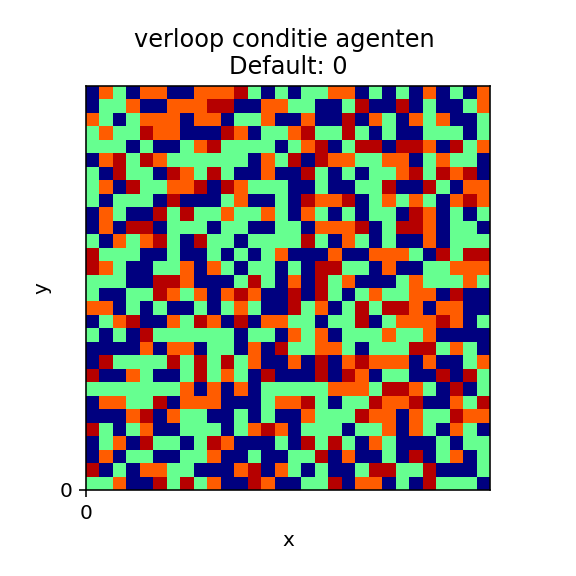
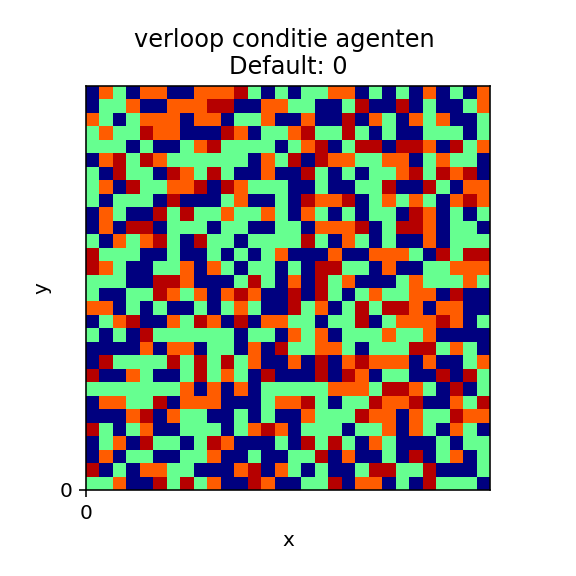
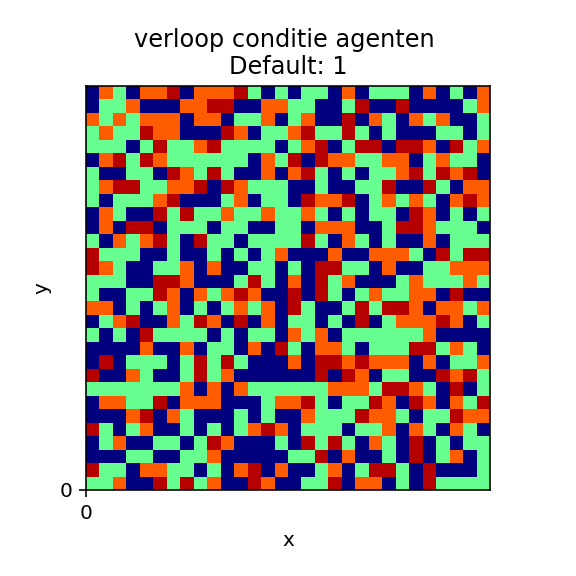
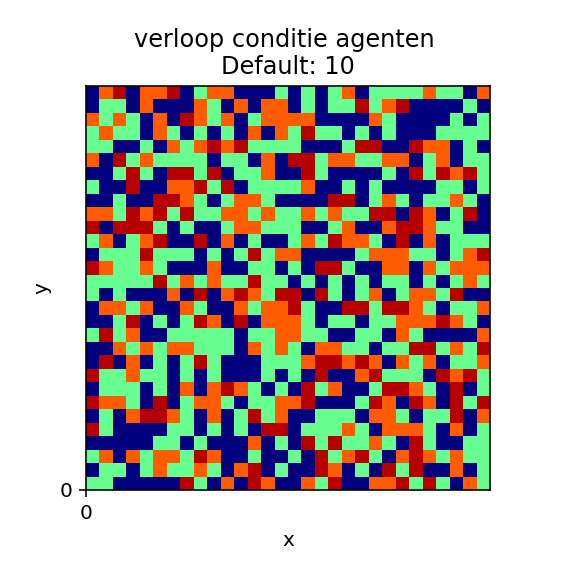
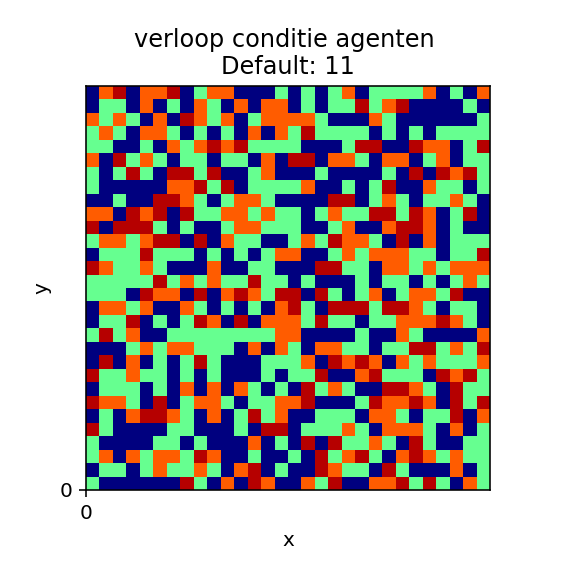
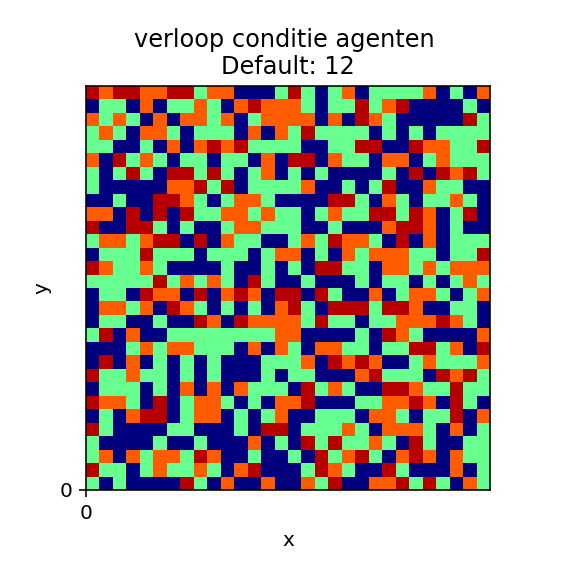
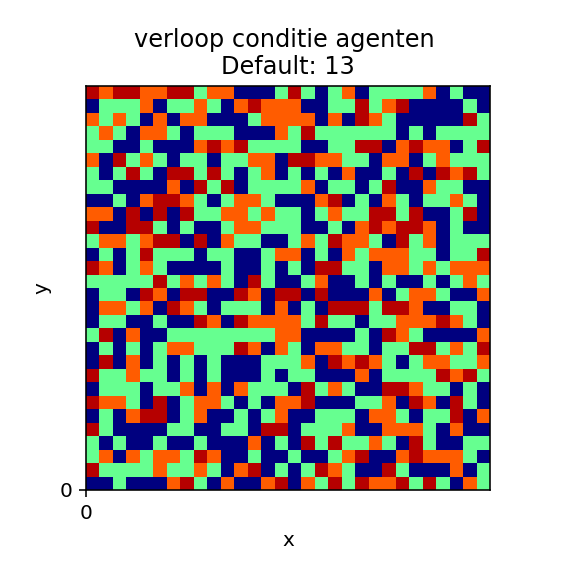
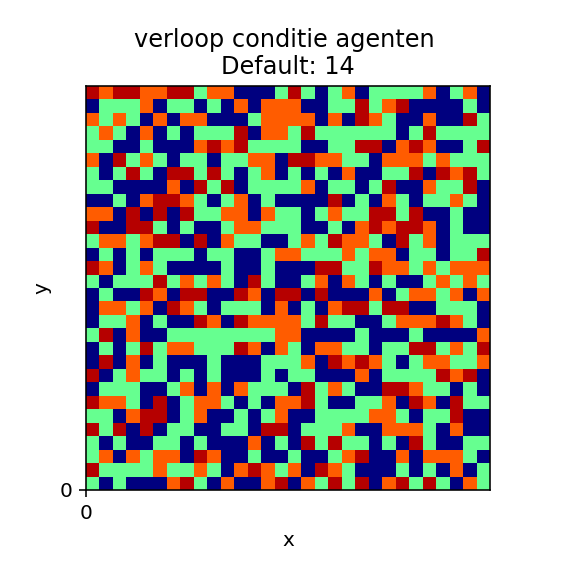
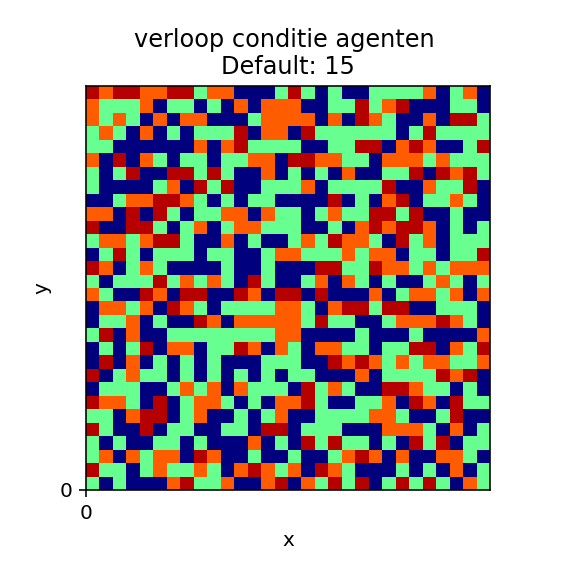
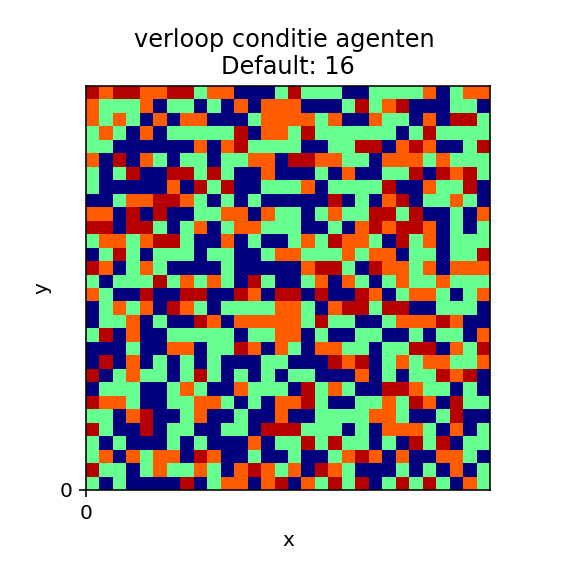
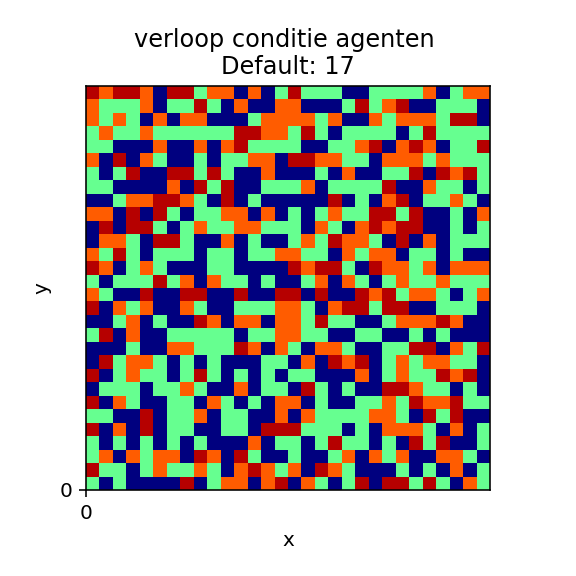
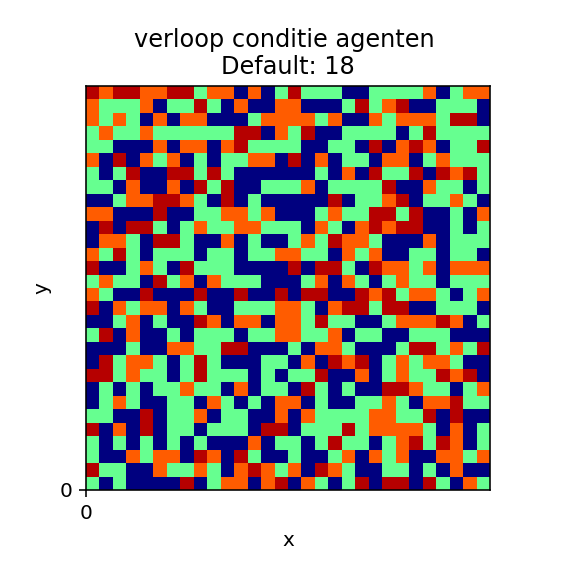
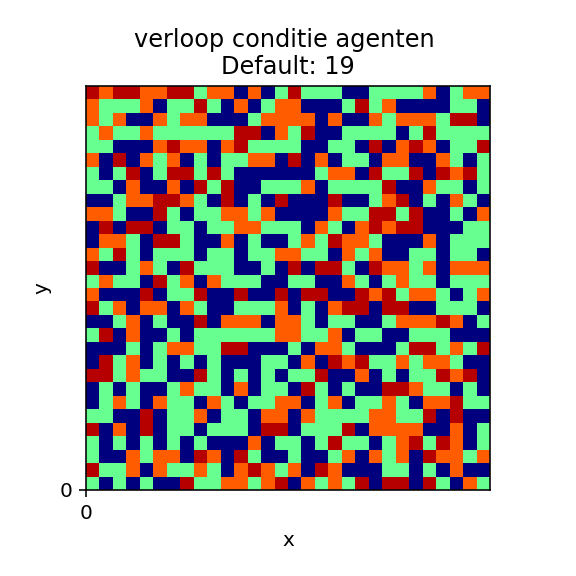
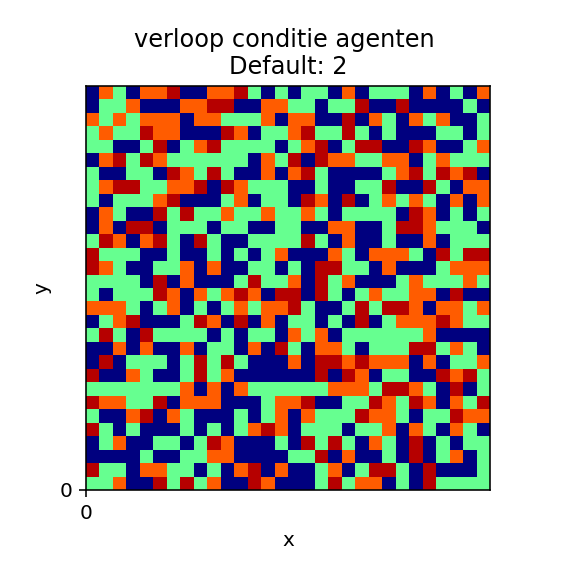
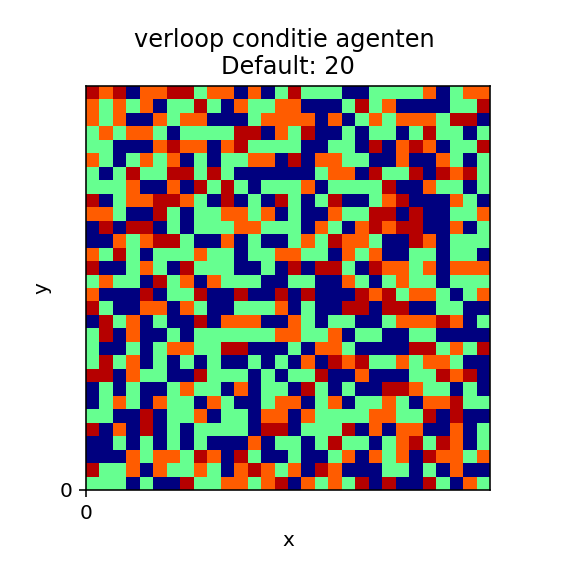
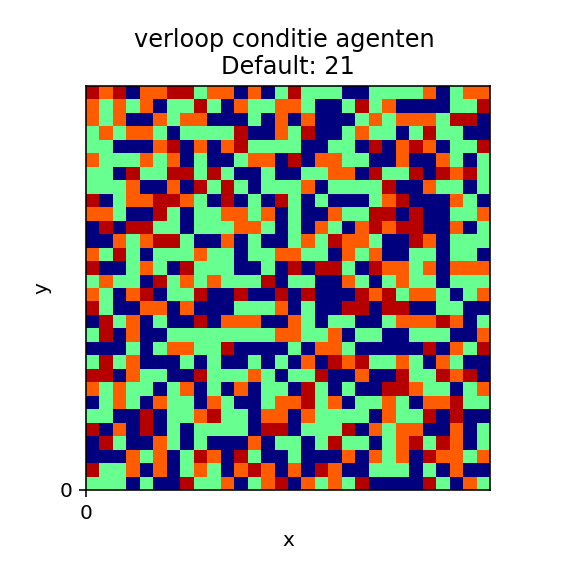
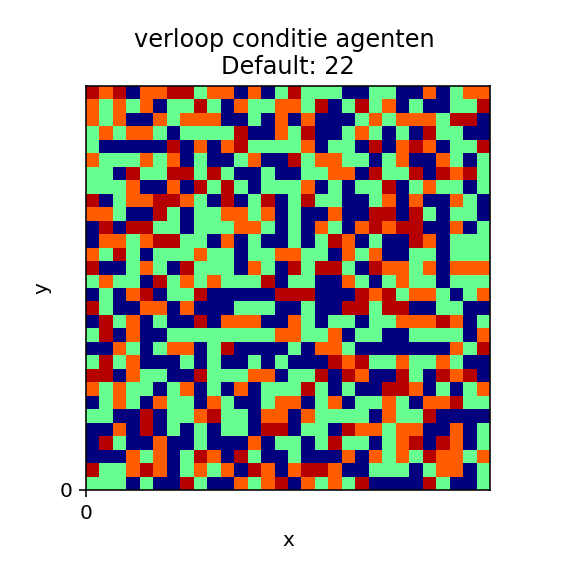
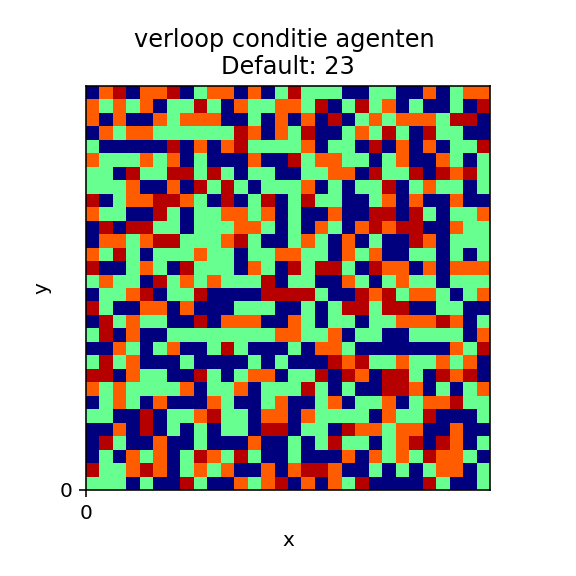
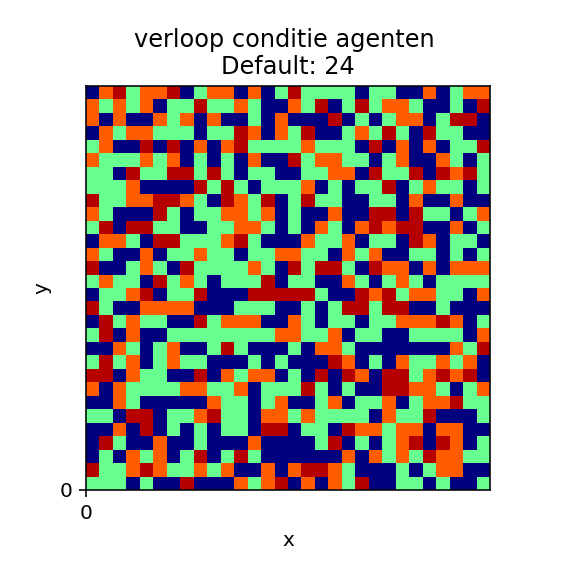
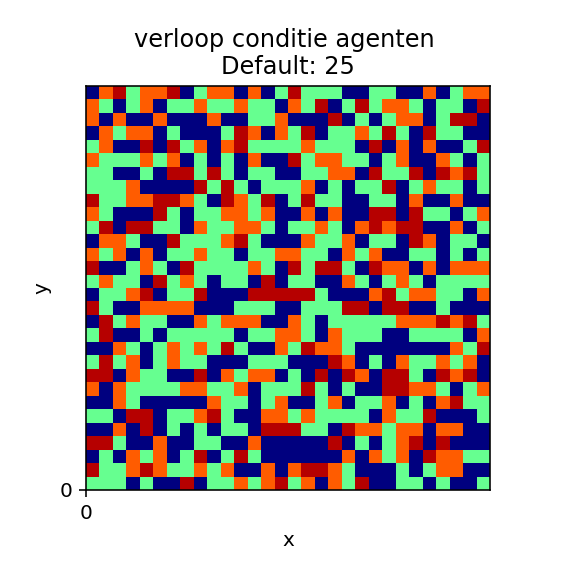
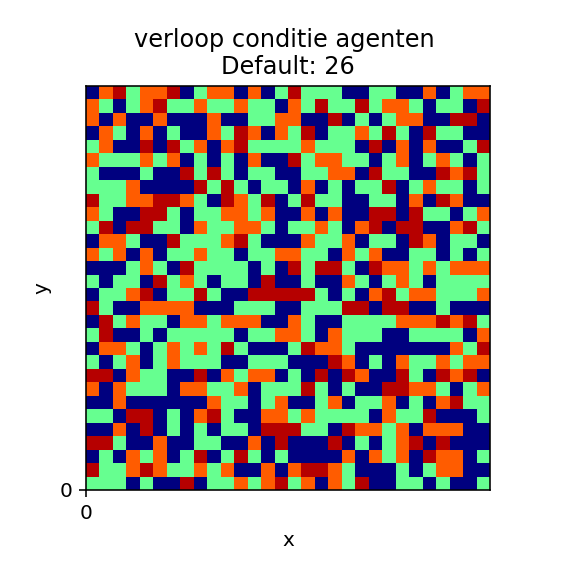
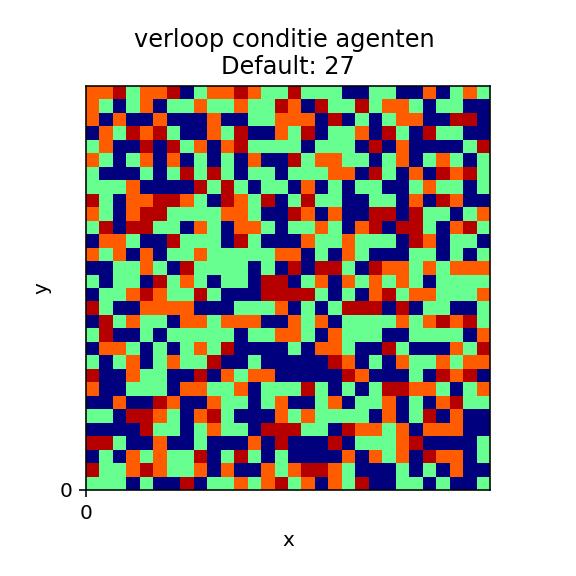
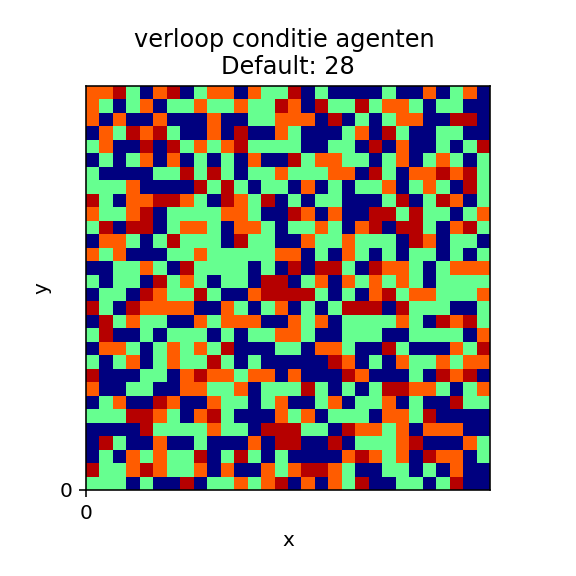
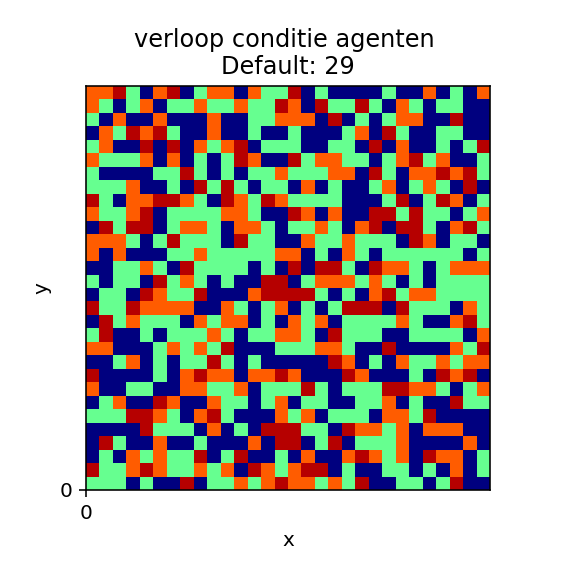
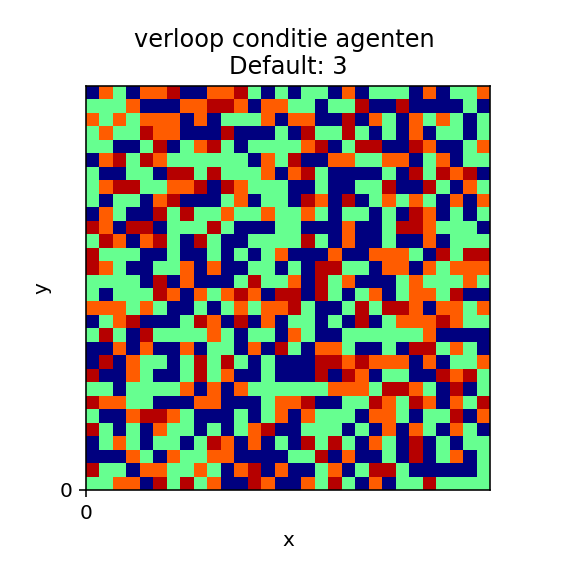
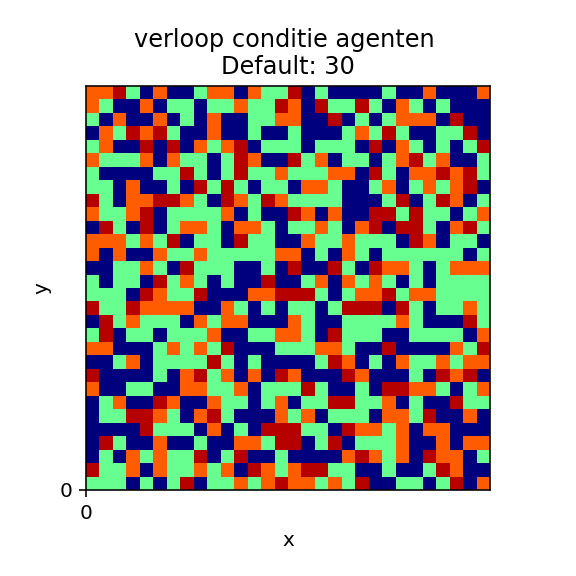
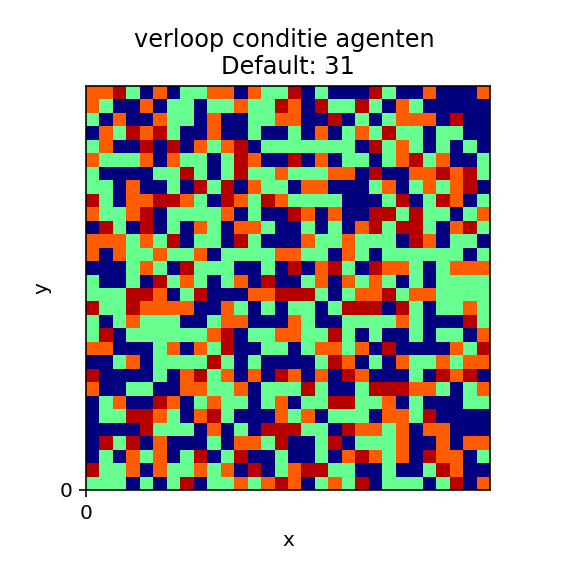
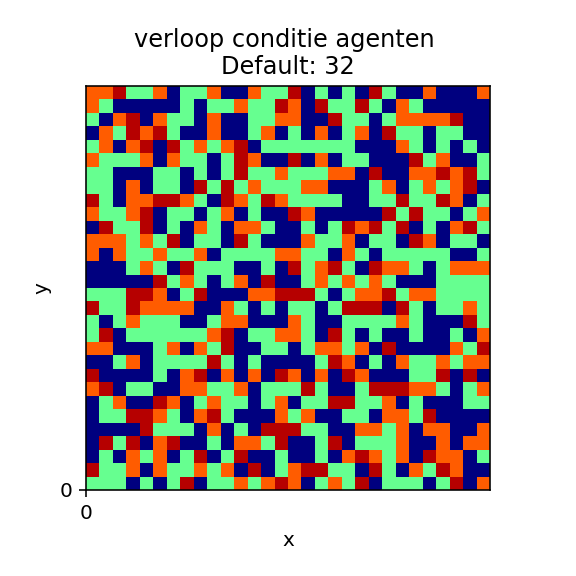
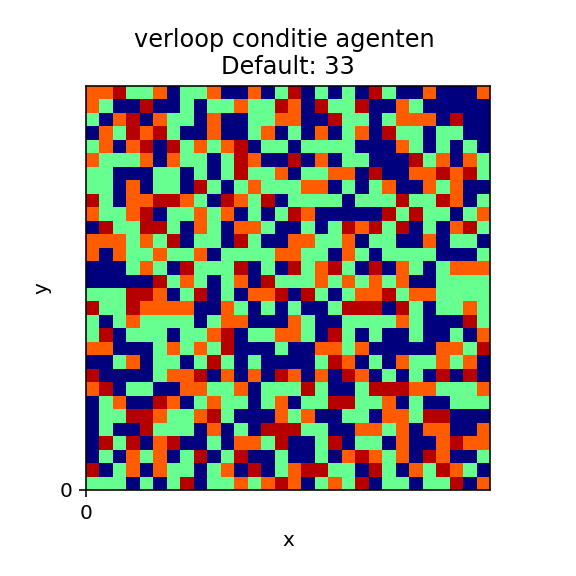
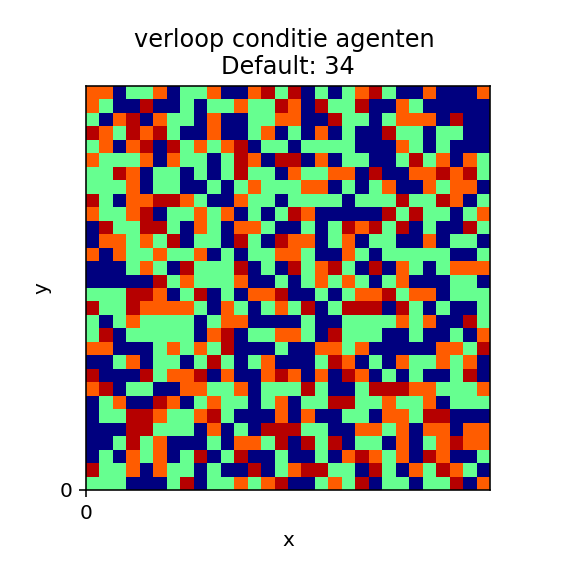
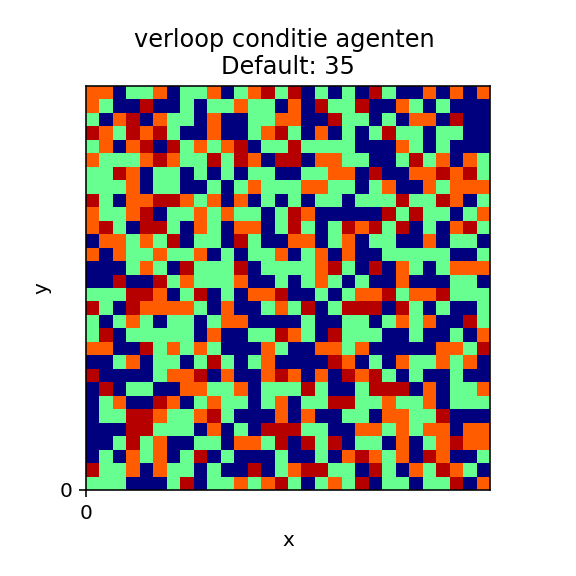
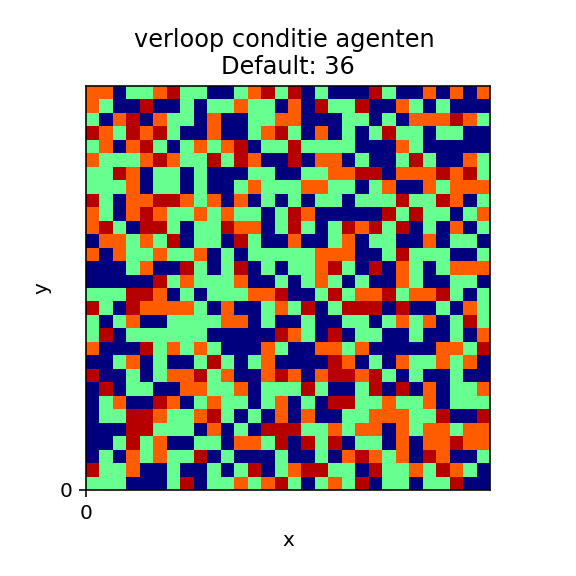
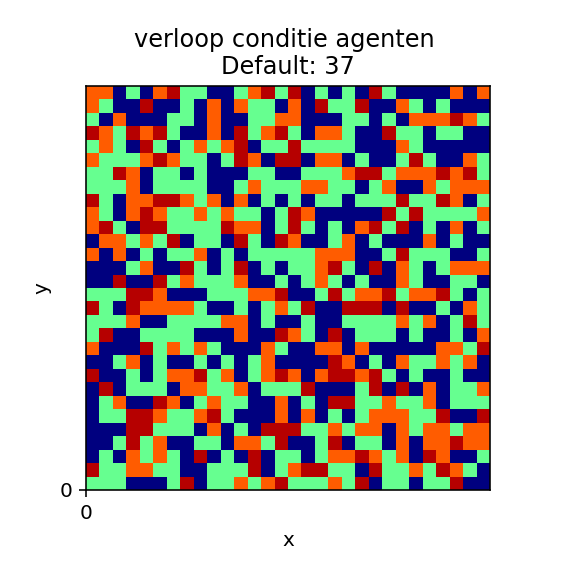
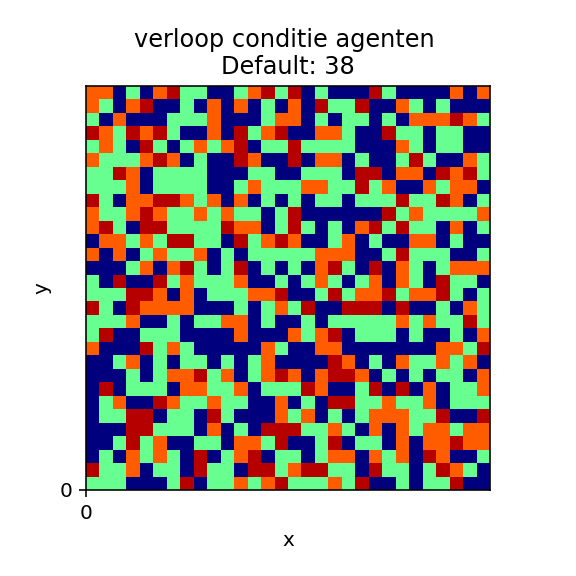
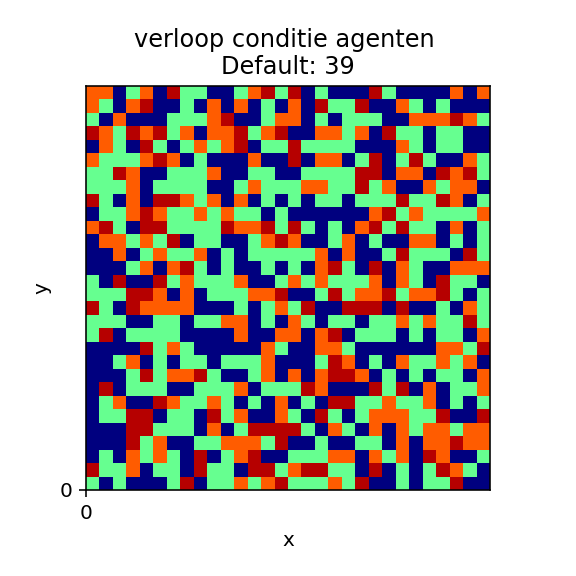
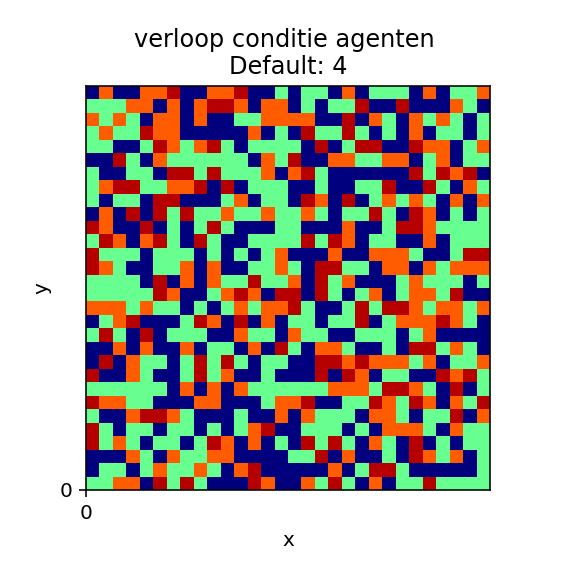
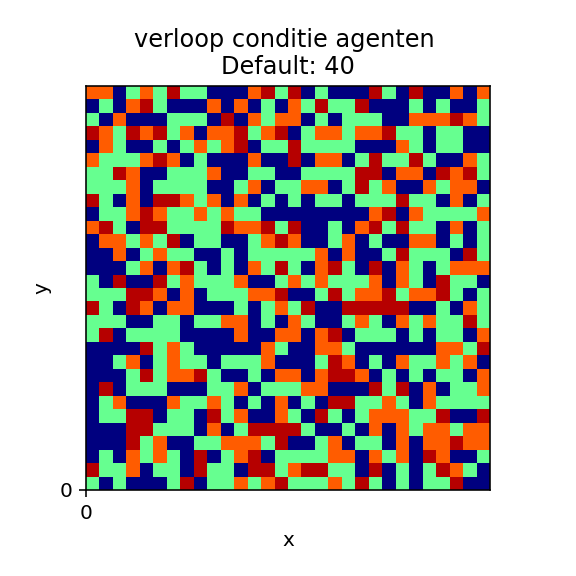
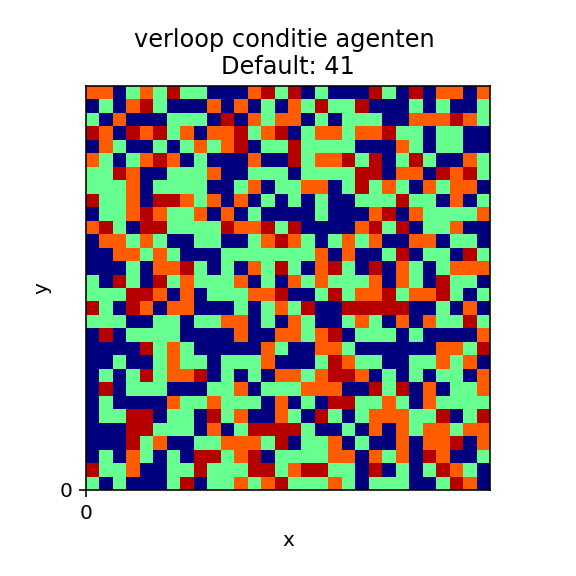
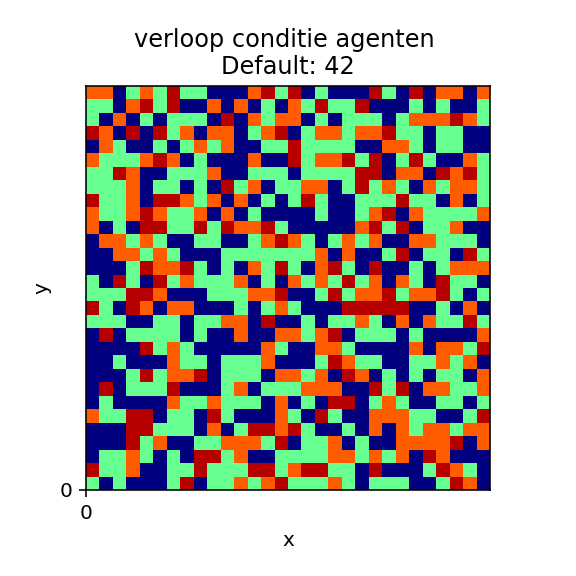
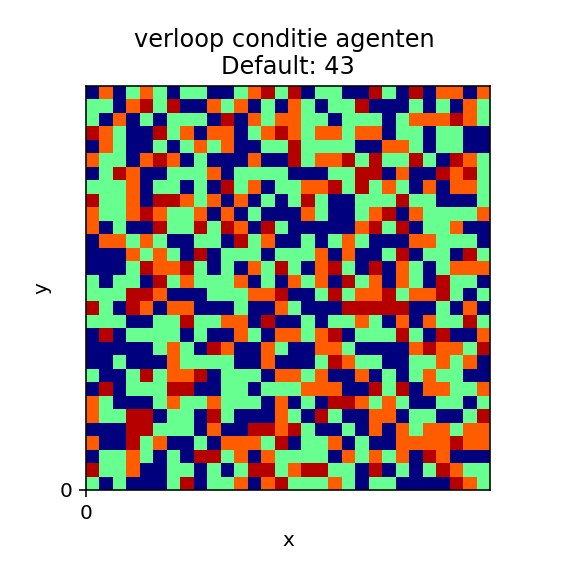
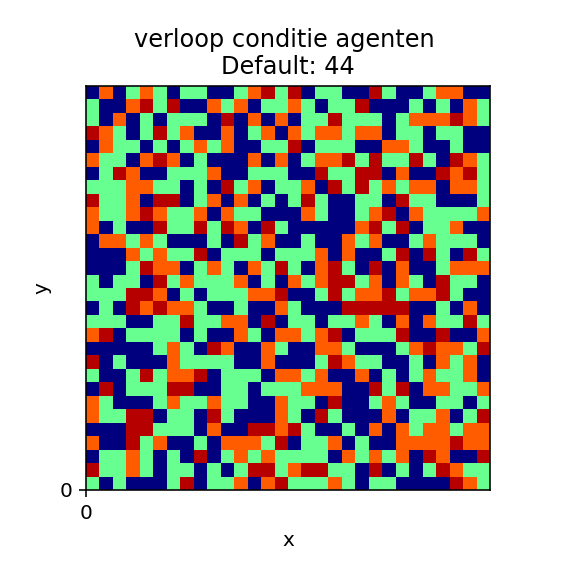
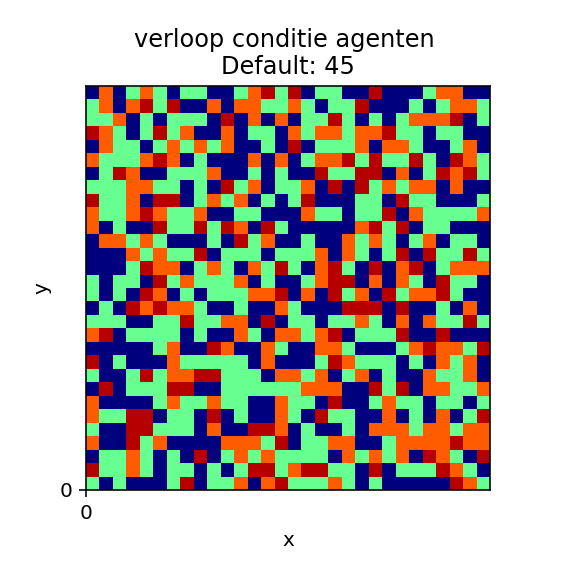
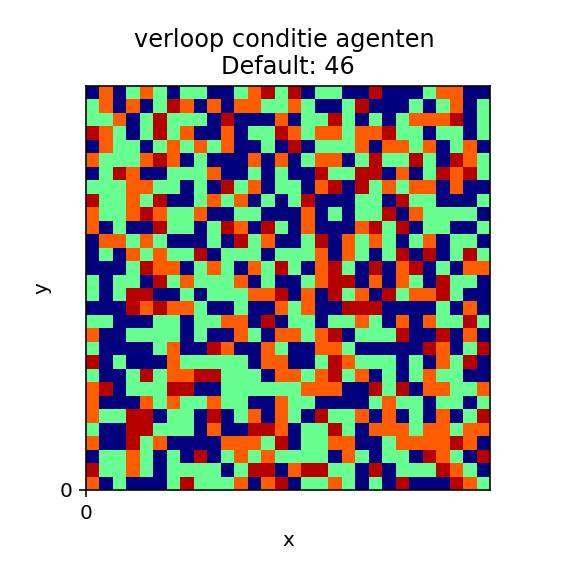
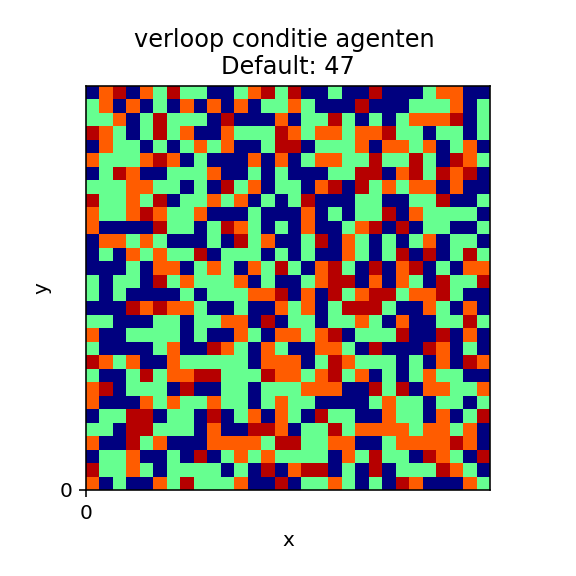
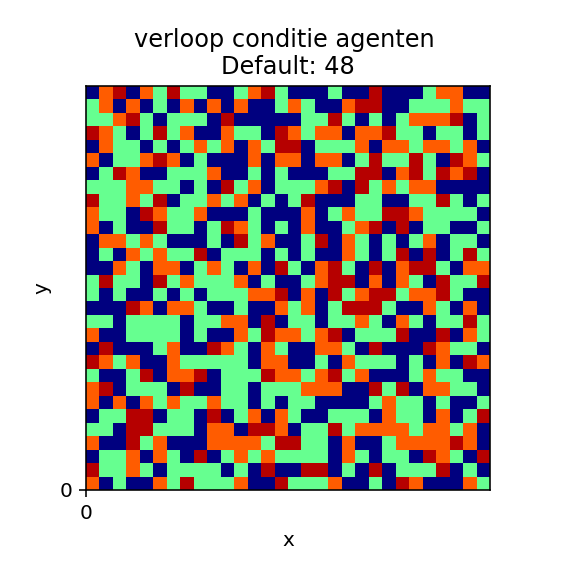
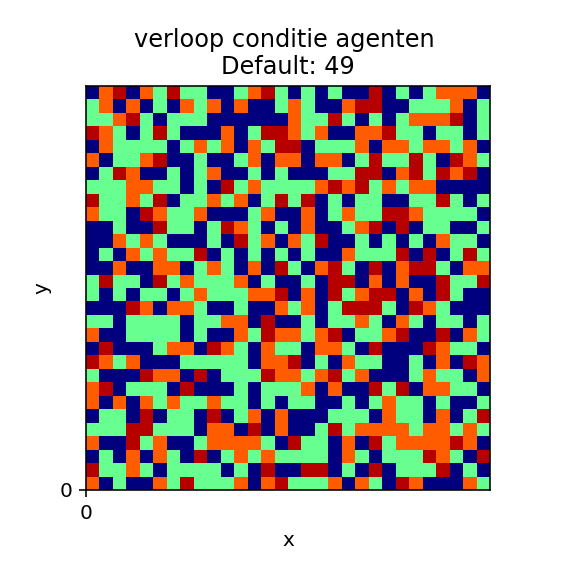
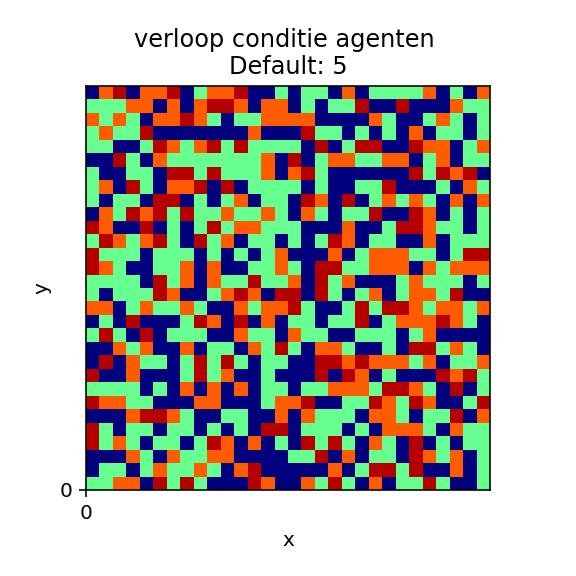
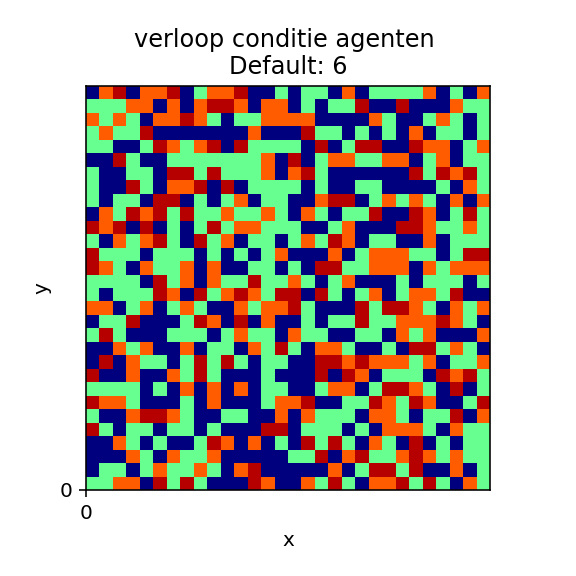
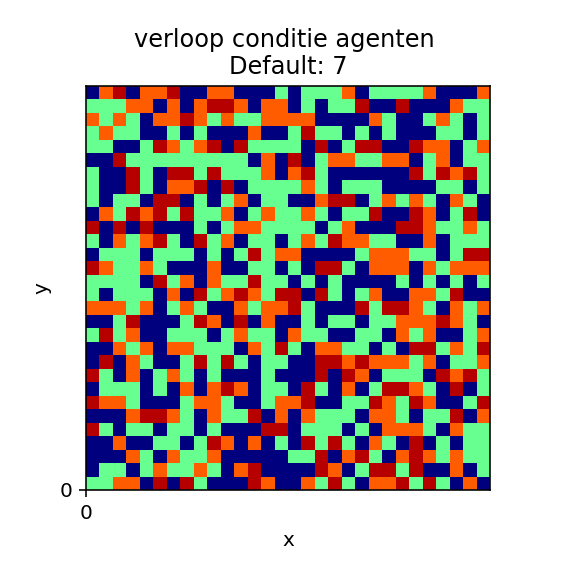
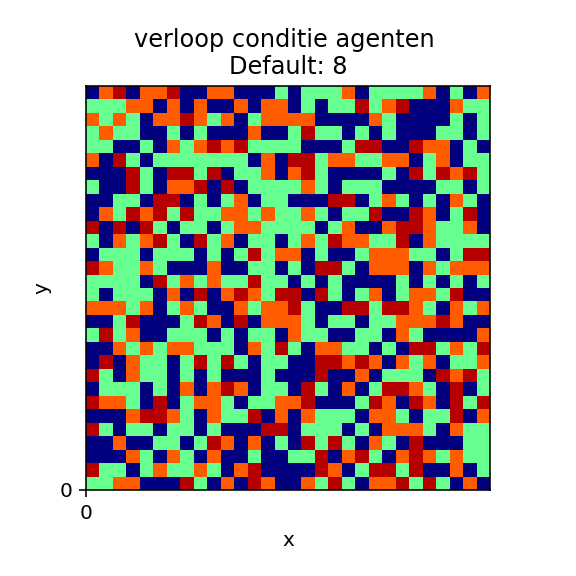
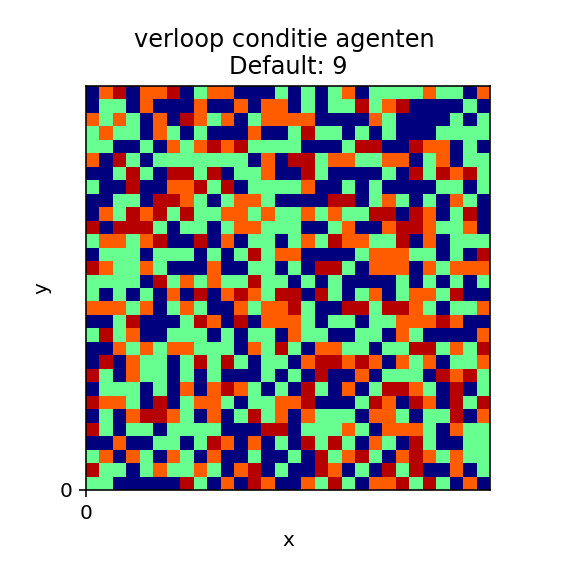

In [4]:
#hier gaan we tekenen
import holoviews as hv
%reload_ext holoviews.ipython

def value(cell):
    if cell is None: return 0   #paars/blauw 
    elif cell.conditie == 'recycle': return 10   #groen
    elif cell.conditie == 'straat': return 20  #bordeauxrood 
    elif cell.conditie == 'restafval': return 17   #lichtblauw 
    elif cell.conditie == 'actief': return 6 #blauw
    elif cell.conditie == 'inactief': return 8 #turqouise 
    elif cell.conditie == "actief_p": return 13 #geel
    elif cell.conditie == "inactief_p": return 3 #donkerder blauw
    
    
hmap = hv.HoloMap()
for i in range(50):   
    model.step()   
    data = np.array([[value(c) for c in row] for row in model.grid.grid])
    data = np.transpose(data)
    data = np.flip(data, axis=0)
    bounds=(0,0,5,5)  
    hmap[i] = hv.Image(data, vdims=[hv.Dimension('a', range=(0,21))],bounds=bounds).relabel('verloop conditie agenten').opts(cmap='jet',xticks=[0],yticks=[0])
hmap

#results = model.datacollector.get_model_vars_dataframe()
#print(results)


In [5]:
results = model.datacollector.get_model_vars_dataframe()
print(results)
results_agents = model.datacollector.get_agent_vars_dataframe()      
print(results_agents)

    recycle  straat  restafval  actief  inactief  actief_p  inactief_p
0       307     120        184       0         0         0           0
1       307     119        185       0         0         0           0
2       308     119        184       0         0         0           0
3       308     119        184       0         0         0           0
4       308     119        184       0         0         0           0
5       309     119        183       0         0         0           0
6       309     119        183       0         0         0           0
7       309     119        183       0         0         0           0
8       309     119        183       0         0         0           0
9       309     119        183       0         0         0           0
10      309     119        183       0         0         0           0
11      309     118        184       0         0         0           0
12      309     118        184       0         0         0           0
13    

In [6]:
results = model.datacollector.get_model_vars_dataframe().iloc[400]
print(results)

IndexError: single positional indexer is out-of-bounds

In [ ]:
print(model.count_inwoner(model, "recycle")) 
print(model.count_inwoner(model, "straat"))
print(model.count_inwoner(model, "restafval"))
print(model.count_vuilnisman(model, "actief"))
print(model.count_vuilnisman(model, "inactief"))

In [ ]:
model.schedule.get_agent_count()

[Text(0.5, 1.0, 'Motivatie basecase')]

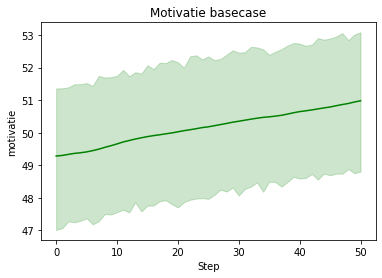

In [10]:
#Voor basecase
sns.lineplot(data = results_agents,  x='Step',y='motivatie',color='green').set(title =  'Motivatie basecase')

[Text(0.5, 1.0, 'Motivatie beleid 1')]

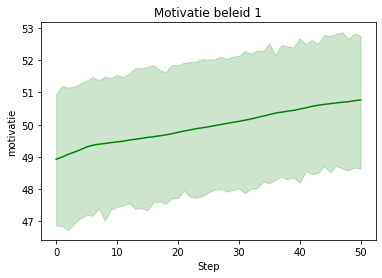

In [19]:
#beleid1
sns.lineplot(data = results_agents,  x='Step',y='motivatie',color='green').set(title = 'Motivatie beleid 1')

[Text(0.5, 1.0, 'Motivatie beleid 2')]

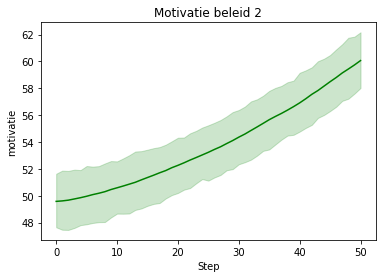

In [27]:
#beleid2 
sns.lineplot(data = results_agents,  x='Step',y='motivatie',color='green').set(title = "Motivatie beleid 2")

[Text(0.5, 1.0, 'Motivatie basecase, scenario 1')]

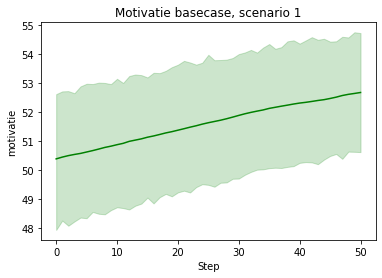

In [65]:
#scenario 1 (basecase)
sns.lineplot(data = results_agents,  x='Step',y='motivatie',color='green').set(title = "Motivatie basecase, scenario 1")

[Text(0.5, 1.0, 'Motivatie basecase, scenario 2')]

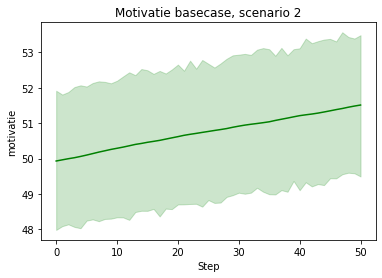

In [72]:
#scenario 2 (basecase)
sns.lineplot(data = results_agents,  x='Step',y='motivatie',color='green').set(title = "Motivatie basecase, scenario 2")

Text(0, 0.5, 'Amount of agents')

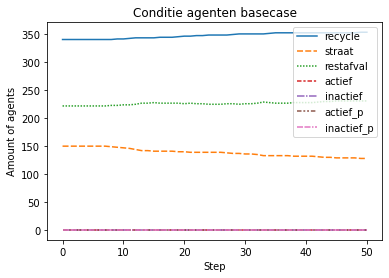

In [11]:
#basecase
sns.lineplot(data = results).set(title = 'Conditie agenten basecase')
plt.xlabel('Step')
plt.ylabel('Amount of agents')

Text(0, 0.5, 'Amount of agents')

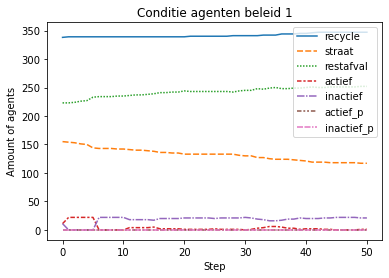

In [20]:
#beleid1
sns.lineplot(data = results).set(title = 'Conditie agenten beleid 1')
plt.xlabel('Step')
plt.ylabel('Amount of agents')

Text(0, 0.5, 'Amount of agents')

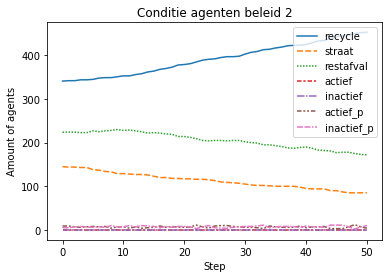

In [28]:
#beleid2
sns.lineplot(data = results).set(title = 'Conditie agenten beleid 2')
plt.xlabel('Step')
plt.ylabel('Amount of agents')

Text(0, 0.5, 'Amount of agents')

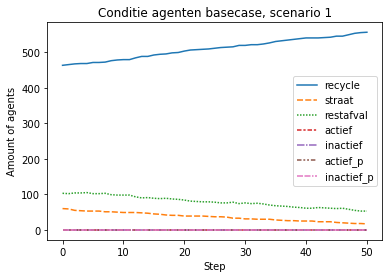

In [66]:
#scenario 1 (basecase)
sns.lineplot(data = results).set(title = 'Conditie agenten basecase, scenario 1')
plt.xlabel('Step')
plt.ylabel('Amount of agents')

Text(0, 0.5, 'Amount of agents')

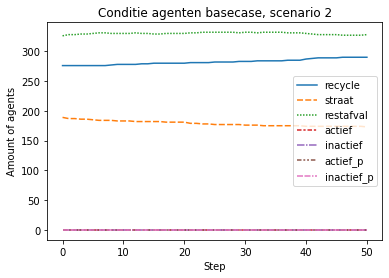

In [73]:
#scenario 2 (basecase)
sns.lineplot(data = results).set(title = 'Conditie agenten basecase, scenario 2')
plt.xlabel('Step')
plt.ylabel('Amount of agents')

In [12]:
#motivatie van basecase
motivatie_basecase = plastic(seed=40)
for i in range(50):
    motivatie_basecase.step()
    
agent_data_basecase = motivatie_basecase.datacollector.get_agent_vars_dataframe()
model_data_basecase = motivatie_basecase.datacollector.get_model_vars_dataframe()

In [21]:
#motvatie van beleid 1
motivatie_beleid1 = plastic(seed=40)
for i in range(50):
    motivatie_beleid1.step()
    
agent_data_beleid1 = motivatie_beleid1.datacollector.get_agent_vars_dataframe()
model_data_beleid1 = motivatie_beleid1.datacollector.get_model_vars_dataframe()

In [29]:
#motivatie van beleid 2
motivatie_beleid2 = plastic(seed=40)
for i in range(50):
    motivatie_beleid2.step()
    
agent_data_beleid2 = motivatie_beleid2.datacollector.get_agent_vars_dataframe()
model_data_beleid2 = motivatie_beleid2.datacollector.get_model_vars_dataframe()


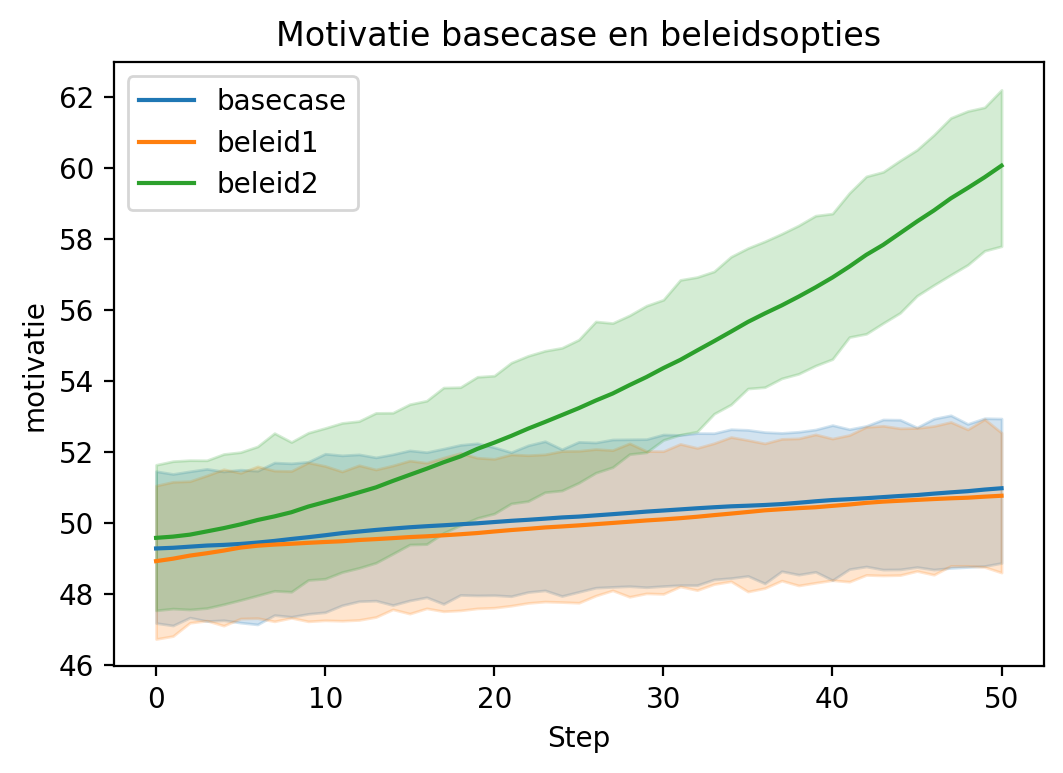

In [32]:
fig, ax = plt.subplots(dpi = 200)
sns.lineplot(data = agent_data_basecase, x='Step',y='motivatie').set(title = "Motivatie basecase en beleidsopties")
sns.lineplot(data = agent_data_beleid1,  x='Step',y='motivatie')
sns.lineplot(data = agent_data_beleid2,  x='Step',y='motivatie')
plt.legend(labels=["basecase","beleid1", "beleid2"])

In [88]:
#motivatie van lst1
motivatie_lst1 = plastic(seed=40)
for i in range(50):
    motivatie_lst1.step()
    
agent_data_lst1 = motivatie_lst1.datacollector.get_agent_vars_dataframe()
model_data_lst1 = motivatie_lst1.datacollector.get_model_vars_dataframe()

In [94]:
#motivatie van lst2
motivatie_lst2 = plastic(seed=40)
for i in range(50):
    motivatie_lst2.step()
    
agent_data_lst2 = motivatie_lst2.datacollector.get_agent_vars_dataframe()
model_data_lst2 = motivatie_lst2.datacollector.get_model_vars_dataframe()

In [101]:
#motivatie van lst3
motivatie_lst3 = plastic(seed=40)
for i in range(50):
    motivatie_lst3.step()
    
agent_data_lst3 = motivatie_lst3.datacollector.get_agent_vars_dataframe()
model_data_lst3 = motivatie_lst3.datacollector.get_model_vars_dataframe()

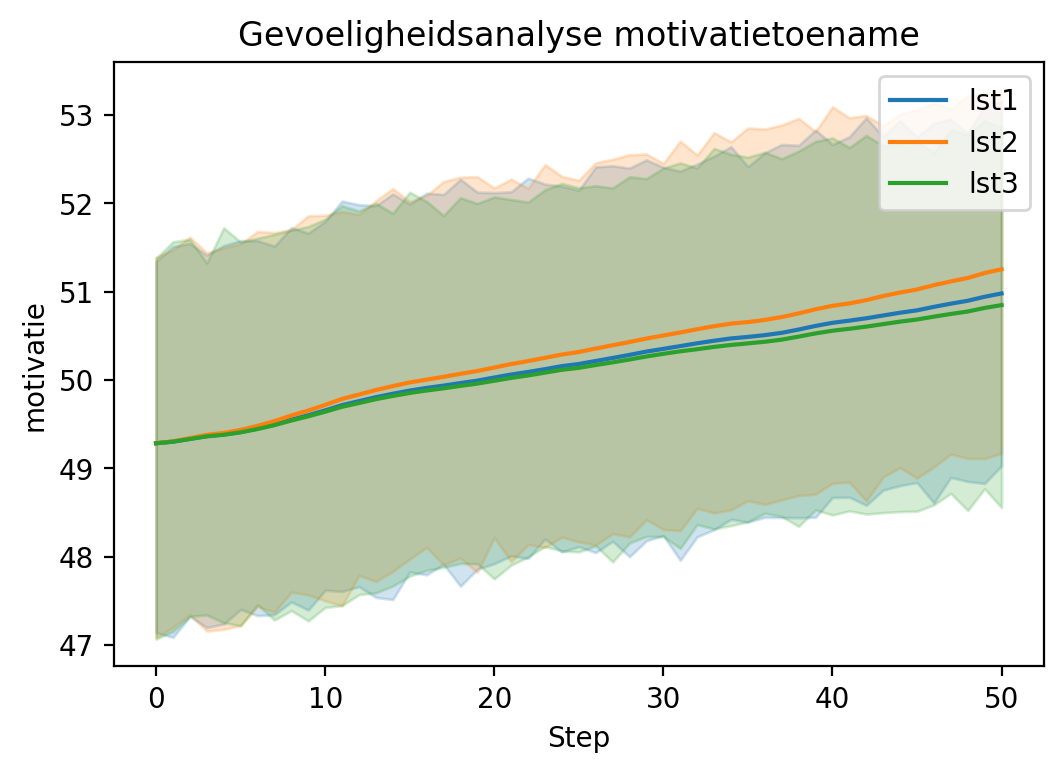

In [102]:
fig, ax = plt.subplots(dpi = 200)
sns.lineplot(data = agent_data_lst1, x='Step',y='motivatie').set(title='Gevoeligheidsanalyse motivatietoename')
sns.lineplot(data = agent_data_lst2,  x='Step',y='motivatie').set(title='Gevoeligheidsanalyse motivatietoename')
sns.lineplot(data = agent_data_lst3,  x='Step',y='motivatie').set(title='Gevoeligheidsanalyse motivatietoename')
plt.legend(labels=["lst1","lst2", "lst3"])

## sns.histplot(data = agent_data_basecase.loc[0], x = "motivatie", color = "red").set(title = "Motivatie basecase stap 1")

[Text(0.5, 1.0, 'Motivatie basecase stap 25')]

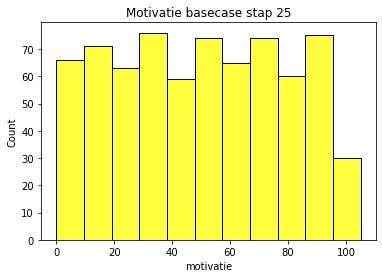

In [80]:
sns.histplot(data = agent_data_basecase.loc[24], x = "motivatie", color = "yellow").set(title = "Motivatie basecase stap 25")


[Text(0.5, 1.0, 'Motivatie basecase stap 50')]

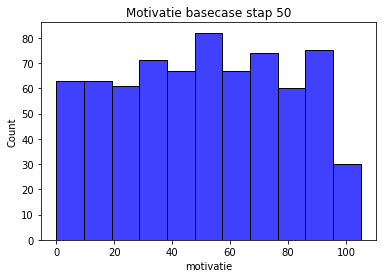

In [78]:
sns.histplot(data = agent_data_basecase.loc[49], x = "motivatie", color = "blue").set(title = "Motivatie basecase stap 50")                                                        


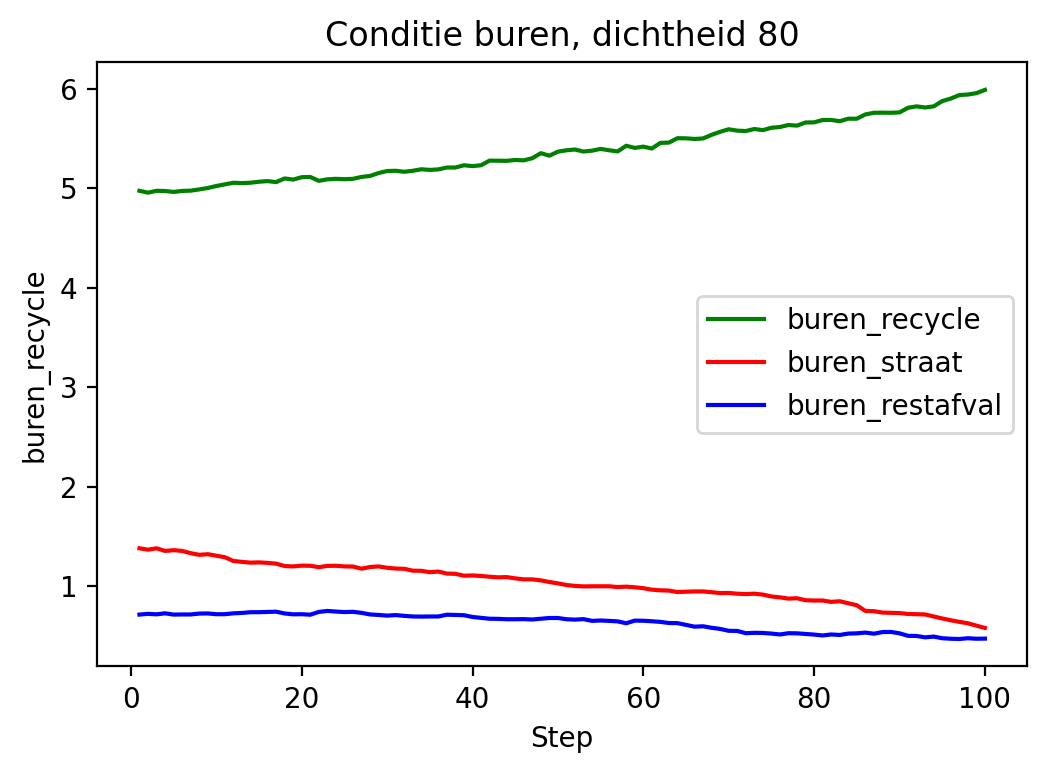

In [169]:
#Verificatie
fig, ax = plt.subplots(dpi=200)
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_recycle',color='green', ci = None).set(title ='Conditie buren, dichtheid 80')
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_straat',color='red', ci = None)
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_restafval',color='blue', ci = None)
plt.legend(labels=["buren_recycle","buren_straat", "buren_restafval"])

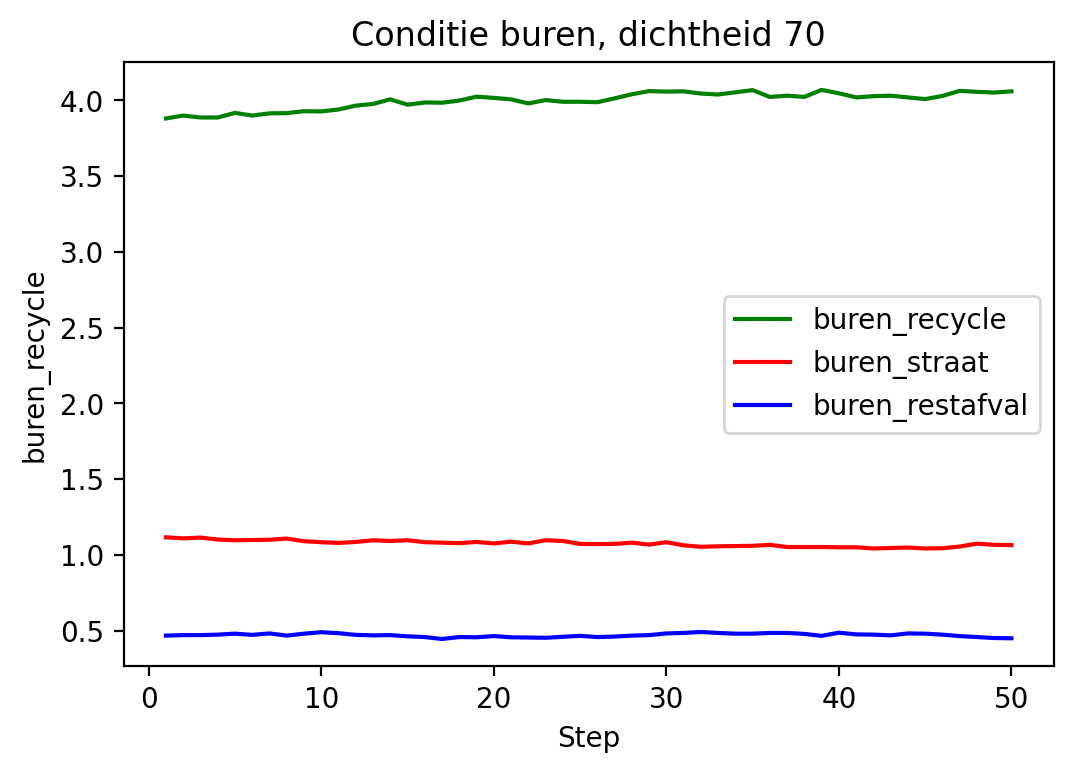

In [186]:
#dichtheid 70
fig, ax = plt.subplots(dpi=200)
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_recycle',color='green', ci = None).set(title ='Conditie buren, dichtheid 70')
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_straat',color='red', ci = None)
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_restafval',color='blue', ci = None)
plt.legend(labels=["buren_recycle","buren_straat", "buren_restafval"])

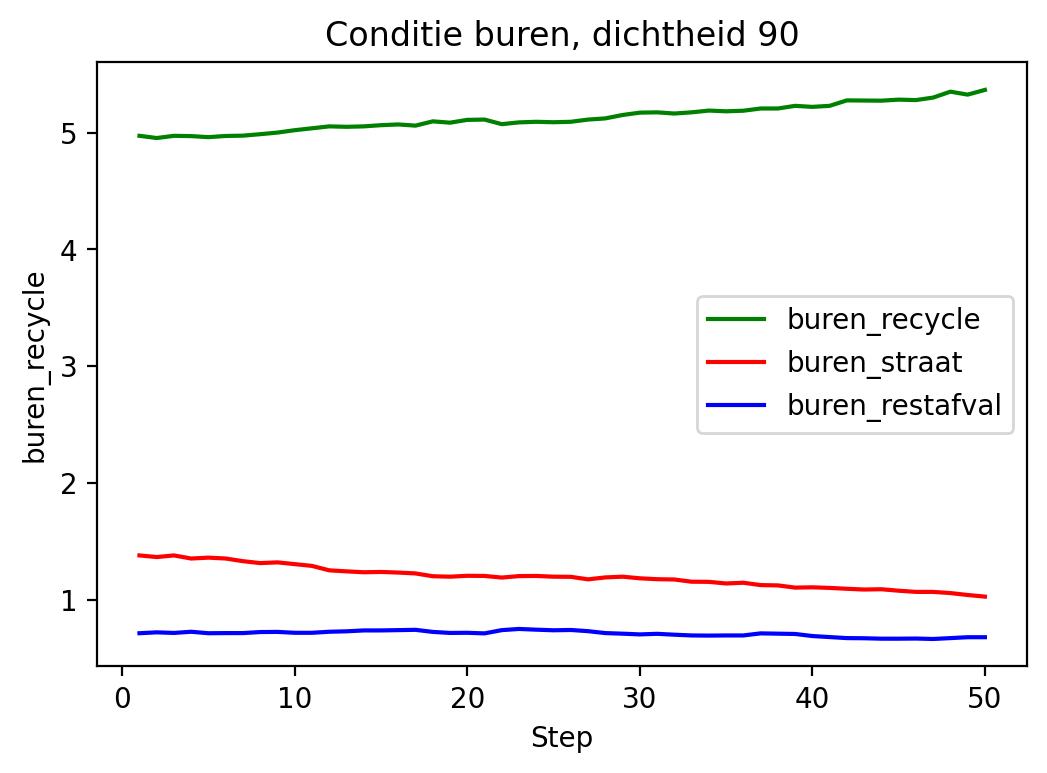

In [181]:
#dichtheid 90
fig, ax = plt.subplots(dpi=200)
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_recycle',color='green', ci = None).set(title ='Conditie buren, dichtheid 90')
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_straat',color='red', ci = None)
sns.lineplot(data = results_agents.loc[1:],  x='Step', y ='buren_restafval',color='blue', ci = None)
plt.legend(labels=["buren_recycle","buren_straat", "buren_restafval"])